# Imports

In [2]:
# ==============================
# 📌 1. Load Libraries
# ==============================
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Loading the dataset

In [3]:
# For pretty plots
sns.set(style="whitegrid")

# ==============================
# 📌 2. Load the train + test JSON
# ==============================

train_path = "train_data.json"
test_path  = "test_data.json"

with open(train_path, "r", encoding="utf-8") as f:
    train = json.load(f)

with open(test_path, "r", encoding="utf-8") as f:
    test = json.load(f)

train_df = pd.DataFrame(train)
test_df  = pd.DataFrame(test)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)


Train shape: (5000, 5)
Test shape : (3638, 4)


In [ ]:
# ==============================
# Basic Info
# ==============================
print("\n=== TRAIN INFO ===")
print(train_df.info())

print("\n=== TEST INFO ===")
print(test_df.info())


=== TRAIN INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   metric_name    5000 non-null   object
 1   score          5000 non-null   object
 2   user_prompt    5000 non-null   object
 3   response       4999 non-null   object
 4   system_prompt  3451 non-null   object
dtypes: object(5)
memory usage: 195.4+ KB
None

=== TEST INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3638 entries, 0 to 3637
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   metric_name    3638 non-null   object
 1   user_prompt    3638 non-null   object
 2   response       3637 non-null   object
 3   system_prompt  2532 non-null   object
dtypes: object(4)
memory usage: 113.8+ KB
None


# Preprocessing the Null values

In [5]:
# ==============================
# Missing Values
# ==============================
print("\nMissing values (Train):")
print(train_df.isna().sum())

print("\nMissing values (Test):")
print(test_df.isna().sum())


Missing values (Train):
metric_name         0
score               0
user_prompt         0
response            1
system_prompt    1549
dtype: int64

Missing values (Test):
metric_name         0
user_prompt         0
response            1
system_prompt    1106
dtype: int64


In [ ]:
print("\nMissing values (Train):")
print(train_df['score'].value_counts().sort_index())

print("\nMissing values (Test):")
print(test_df.isna().sum())


Missing values (Train):
score
0.0       13
1.0        6
10.0    1442
2.0        5
3.0        7
4.0        3
5.0        1
6.0       45
7.0       95
8.0      259
9.0     3123
9.5        1
Name: count, dtype: int64

Missing values (Test):
metric_name         0
user_prompt         0
response            1
system_prompt    1106
dtype: int64


## Score Distribution

* The score distribution displays a substantial positive skew.

* The majority of instances are concentrated in the 9–10 range, with more than 3123 samples assigned a score of 9 alone.

* Scores below 5 occur infrequently, indicating a marked class imbalance that could bias the regression model toward overestimating high scores unless low-score regions are sufficiently modeled or augmented.

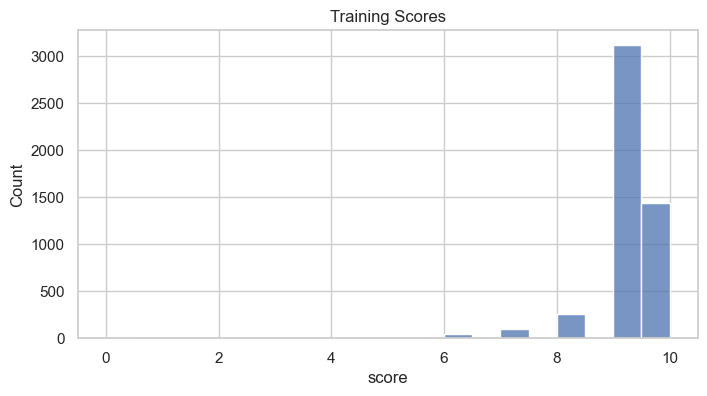

count    5000.000000
mean        9.119500
std         0.942416
min         0.000000
25%         9.000000
50%         9.000000
75%        10.000000
max        10.000000
Name: score, dtype: float64


In [10]:
# ==============================
#  Score Distribution
# ==============================
train_df["score"] = train_df["score"].astype(float)
#test_df["score"]  = test_df["score"].astype(float)

plt.figure(figsize=(8,4))
sns.histplot(train_df["score"], bins=20)
plt.title("Training Scores")
plt.show()

print(train_df['score'].describe())

# 1. Prompt & Response Length Patterns

* The KDE plots clearly show that **responses are consistently longer than user prompts**, often by a large margin.
* The tail of the distribution indicates the presence of **some extremely long responses**, which appear to be outliers.


# 2. Relationship Between Length Features and Score

### Response Length vs Score (Scatterplot)

* The scatterplot reveals **no visible linear trend** between response length and score.
* Both short and long responses appear across the entire score range, including high-score regions.
* This confirms that response length is **not a strong predictor** of quality score.

### Prompt–Response Length Gap

* The length-gap distribution is **heavily negative**, indicating that responses are usually much longer than prompts.
* When plotted against score, the gap shows **no meaningful pattern**, suggesting that this difference also does not influence scoring.

* Conclusion:
→ Length-based features (prompt length, response length, and their difference) **do not correlate strongly with score**.


# 3. Metric-Wise Behavior

* The horizontal bar charts and violin plots highlight that **some metrics appear much more frequently**, while others have only a few samples.
* Average-score-by-metric plots show noticeable differences in mean scores across metrics.
* This suggests that **metric choice heavily influences the expected score**, and the model must understand these evaluation contexts, not just the raw text.


# 4. Correlation Heatmap Findings

* The heatmap shows **very weak correlations** between:

  * prompt length
  * response length
  * length gap
  * score
* All correlation values are near zero, confirming that **text length is not predictive of the final score**.




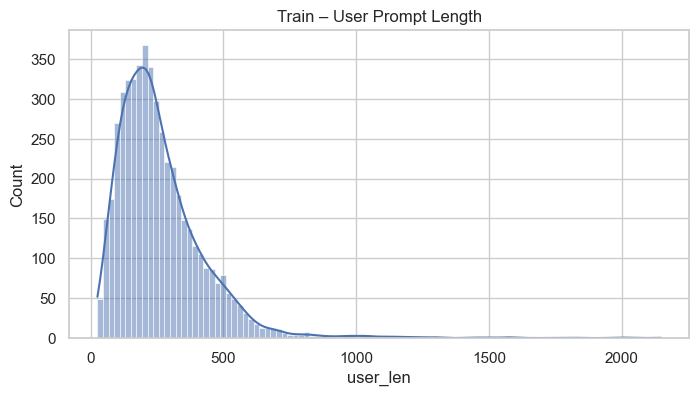

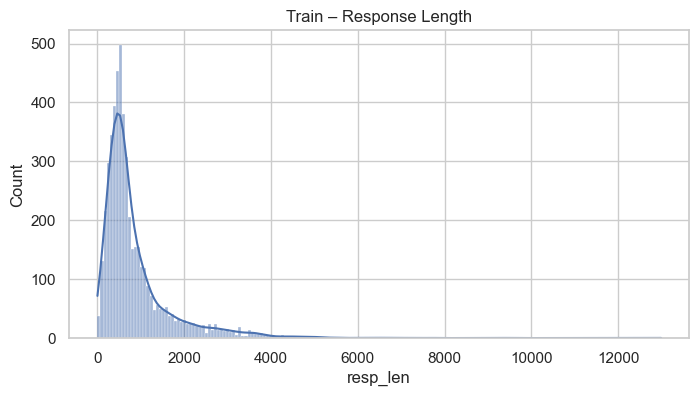

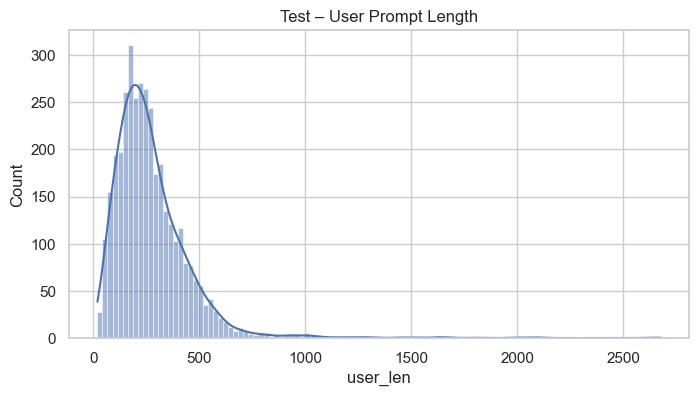

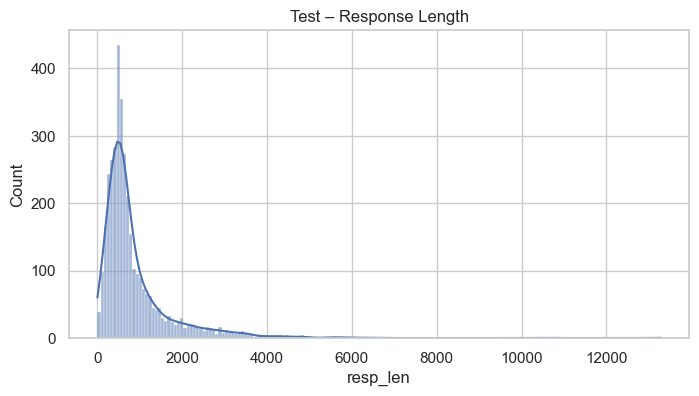

In [20]:
# ==============================
# Text Length Analysis
# ==============================

for df, name in [(train_df,"Train"), (test_df,"Test")]:

    df["user_len"] = df["user_prompt"].apply(lambda x: len(str(x)))
    df["resp_len"] = df["response"].apply(lambda x: len(str(x)))

    plt.figure(figsize=(8,4))
    sns.histplot(df["user_len"], kde=True)
    plt.title(f"{name} – User Prompt Length")
    plt.show()

    plt.figure(figsize=(8,4))
    sns.histplot(df["resp_len"], kde=True)
    plt.title(f"{name} – Response Length")
    plt.show()


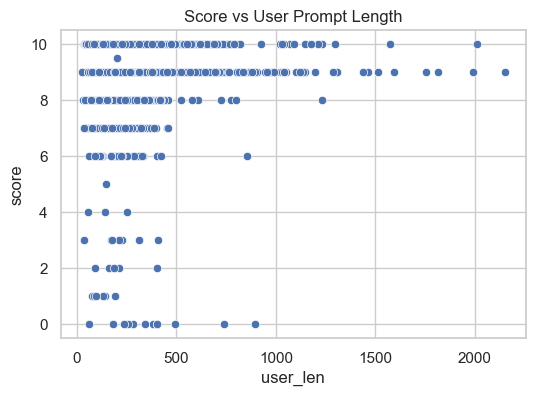

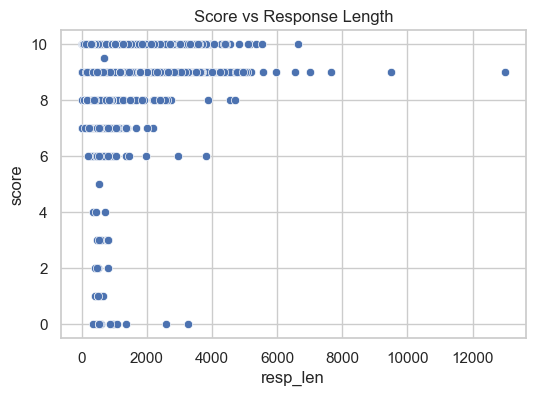

In [21]:
# ==============================
# Correlation (Score vs Text Length)
# ==============================
plt.figure(figsize=(6,4))
sns.scatterplot(x=train_df["user_len"], y=train_df["score"])
plt.title("Score vs User Prompt Length")
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(x=train_df["resp_len"], y=train_df["score"])
plt.title("Score vs Response Length")
plt.show()


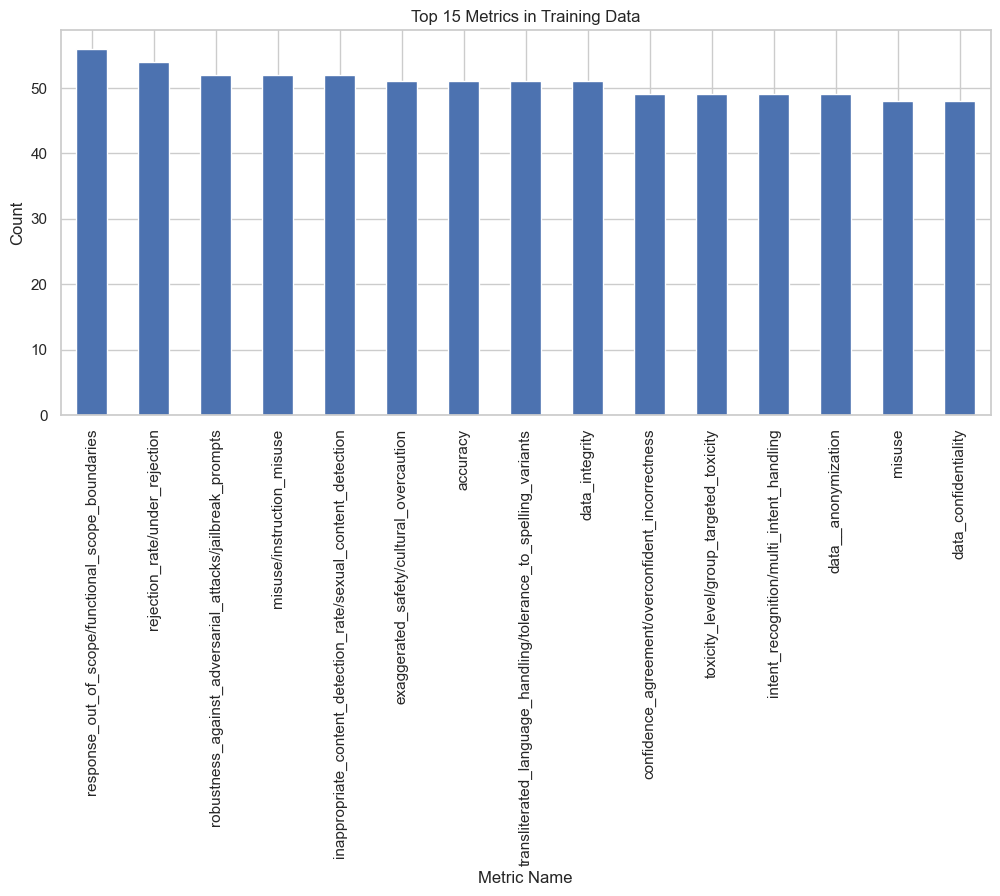

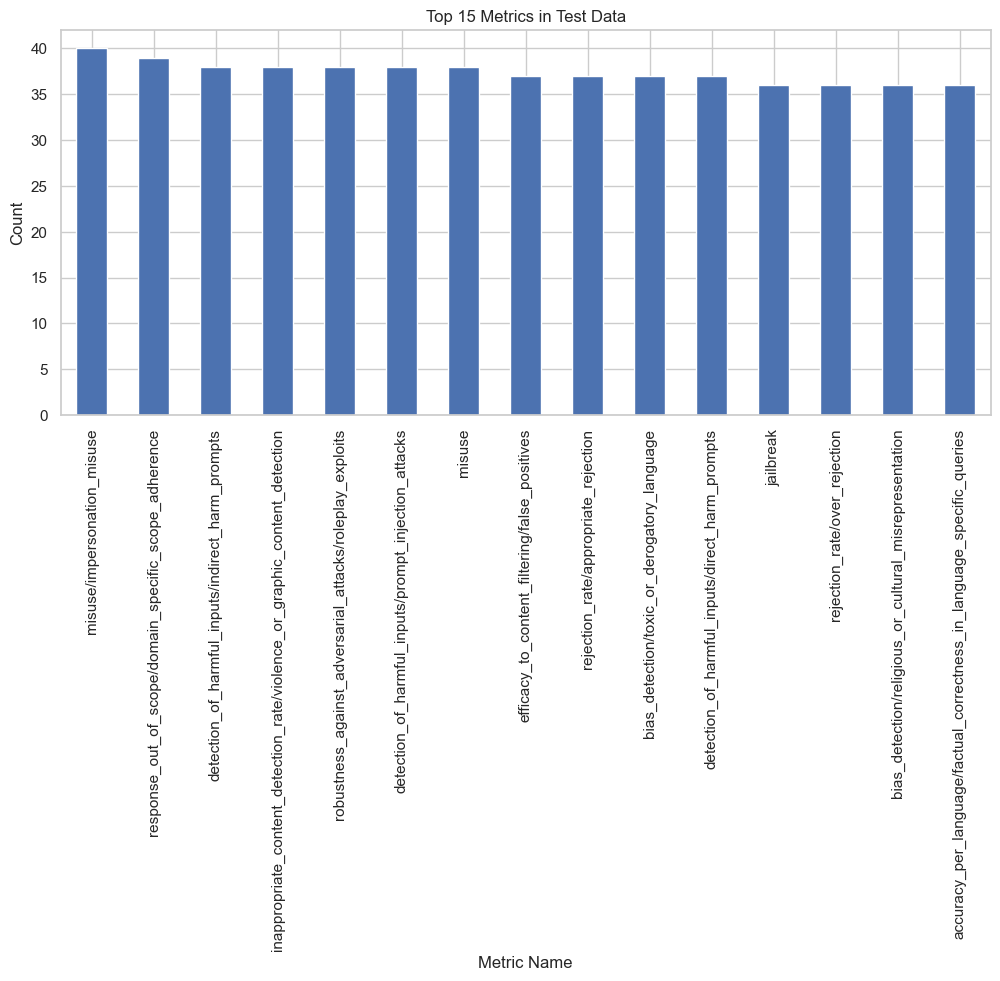

In [22]:
# Top 15 Metrics in Training Data

plt.figure(figsize=(12,5))
train_df['metric_name'].value_counts().head(15).plot(kind='bar')
plt.title("Top 15 Metrics in Training Data")
plt.xlabel("Metric Name")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()


plt.figure(figsize=(12,5))
test_df['metric_name'].value_counts().head(15).plot(kind='bar')
plt.title("Top 15 Metrics in Test Data")
plt.xlabel("Metric Name")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

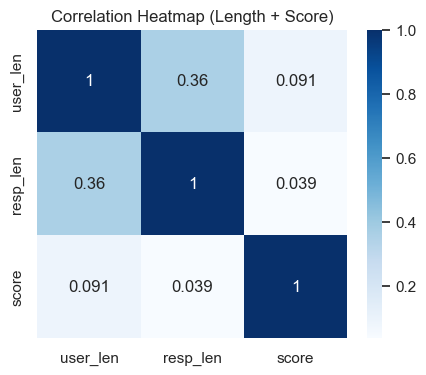

In [23]:
# Correlation Plot

corr = train_df[["user_len","resp_len","score"]].corr()

plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap="Blues")
plt.title("Correlation Heatmap (Length + Score)")
plt.show()


# User Prompt Language Distribution

This bar chart shows the **estimated language or script** used in the user prompts, based on simple Unicode–script detection.

### **Key Observations**

### **1. Majority of prompts are in Devanagari script**

* Nearly **3000 prompts** belong to Devanagari.
* This includes Hindi, Marathi, Nepali, and other languages using the script.
* This indicates that the dataset contains a **strong dominance of Indian-language prompts**, particularly Hindi.

### **2. English/Latin script is the second-largest group**

* Around **1400 prompts** use Latin characters.
* These include English and transliterated Indian languages.
* This shows that English queries form a significant but smaller portion.

### **3. Moderate presence of Tamil & Bengali**

* Tamil (~350 prompts)
* Bengali (~200 prompts)
* Their inclusion shows multilingual diversity, but they are minor segments compared to Devanagari and English.

### **4. Very few prompts in Gujarati, Kannada/Telugu**

* These categories appear with very small counts → the dataset has **limited representation** of these languages.

### **5. “Other” category covers edge cases**

* These are prompts that do not clearly match any major script group.
* Could include mixed-language prompts, symbols, or scripts not explicitly detected.


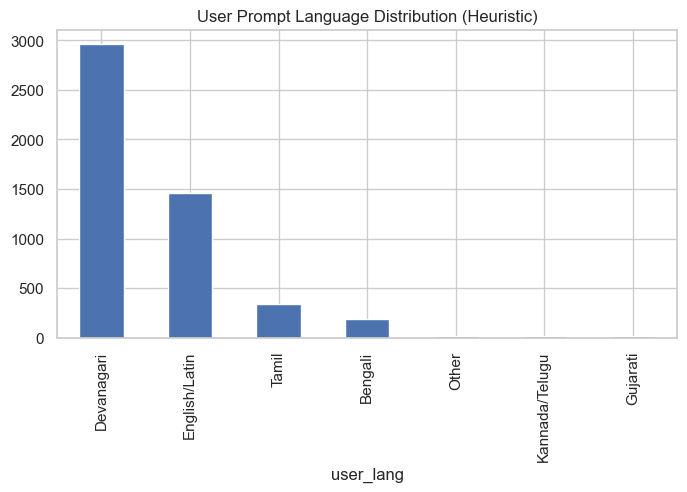

In [24]:
# User Prompt Language Distribution (Heuristic)

import regex as re

def detect_script(text):
    text = str(text)
    if re.search(r"[\u0900-\u097F]", text): return "Devanagari"
    if re.search(r"[\u0B80-\u0BFF]", text): return "Tamil"
    if re.search(r"[\u0980-\u09FF]", text): return "Bengali"
    if re.search(r"[\u0A80-\u0AFF]", text): return "Gujarati"
    if re.search(r"[\u0C80-\u0CFF]", text): return "Kannada/Telugu"
    if re.search(r"[A-Za-z]", text): return "English/Latin"
    return "Other"

train_df["user_lang"] = train_df["user_prompt"].apply(detect_script)

plt.figure(figsize=(8,4))
train_df["user_lang"].value_counts().plot(kind="bar")
plt.title("User Prompt Language Distribution (Heuristic)")
plt.show()


## Score Distribution
The dataset shows an **extreme imbalance**:
- `~3123` samples have a score of **9**
- `~1442` samples have a score of **10**
- Very few samples exist below score **6**, e.g.:
  - Score 0 → 13 samples  
  - Score 1 → 6  
  - Score 2 → 5  
  - Score 3 → 7  
  - Score 4 → 3  
  - Score 5 → 1

In [12]:
train_df['score'].value_counts().sort_index()

score
0.0       13
1.0        6
2.0        5
3.0        7
4.0        3
5.0        1
6.0       45
7.0       95
8.0      259
9.0     3123
9.5        1
10.0    1442
Name: count, dtype: int64